In [320]:
%load_ext autoreload
%autoreload 2
import numpy as np
from eden.util import configure_logging
import logging
logger = logging.getLogger()
configure_logging(logger,verbosity=1)
from IPython.core.display import HTML
HTML('<style>.container { width:95% !important; }</style>')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [321]:
%matplotlib inline
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import mpld3
from mpld3 import plugins, utils
#mpld3.enable_notebook()

In [322]:
import collections

def select_targets(y, min_threshold=10, max_threshold=None):
    """Return the set of targets that are occurring a number of times bounded by min_threshold and max_threshold """
    c = collections.Counter(y)
    y_sel=[]
    for y_id in c:
        if c[y_id] > min_threshold:
            if max_threshold:
                if c[y_id] < max_threshold:
                    y_sel.append(y_id)
            else:
                y_sel.append(y_id)
    return y_sel

def filter_dataset(data_matrix, y, y_sel):
    """Filter data matrix and target vector selecting only instances that belong to y_sel"""
    targets=[]
    instances=[]
    for target,instance in zip(y,data_matrix):
        if target in y_sel:
            targets.append(target)
            instances.append(instance)
    y = np.array(np.hstack(targets))
    data_matrix = np.array(np.vstack(instances))
    return data_matrix, y

In [323]:
def plot(X, y, preds, scores, score):
    size=8
    cmap = 'rainbow'

    print('embedding score: %.2f'%score)
    from sklearn.metrics import adjusted_rand_score
    print('ari: %.2f'%adjusted_rand_score(y,preds))
    plt.figure(figsize=(2 * size, size))
    
    plt.subplot(121)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.scatter(X[:, 0], X[:, 1], c=scores, cmap='Greys', s=95, edgecolors='none')
    plt.scatter(X[:, 0], X[:, 1], alpha=0.55, c=preds, cmap=cmap, s=30, edgecolors='none')
    plt.title('%d predicted classes'%len(set(preds)))
    
    plt.subplot(122)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.scatter(X[:, 0], X[:, 1], c=y, cmap=cmap, alpha=.7, s=30, edgecolors='black')
    plt.title('%d true classes'%len(set(y)))
    plt.show()

In [357]:
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import StratifiedKFold
import networkx as nx
from collections import defaultdict
import numpy as np
from eden.graph_layout_embedder import GraphLayoutEmbedder


def cluster(X, damping=0.5):
    from sklearn.cluster import AffinityPropagation
    clusterer = AffinityPropagation(damping=damping, max_iter=200, convergence_iter=15, copy=True, preference=None, affinity='euclidean', verbose=False)
    y = clusterer.fit_predict(X)
    return y
    
def cluster(X, n_clusters=2):
    from sklearn.cluster import KMeans
    clusterer=KMeans(n_clusters=n_clusters, init='k-means++', n_init=10, max_iter=50)
    y = clusterer.fit_predict(X)
    return y                       
                       
def compute_probs(X,y, is_kernel_matrix=False):
    lr = LogisticRegression()
    skf = StratifiedKFold(y, n_folds=3)
    results=[]
    for train_index, test_index in skf:
        if is_kernel_matrix is False:
            X_train, X_test = X[train_index], X[test_index]
        else:
            X_train, X_test = X[np.ix_(train_index, train_index)], X[np.ix_(test_index, test_index)]
        y_train, y_test = y[train_index], y[test_index]
        lr.fit(X_train, y_train)
        probs = lr.predict_proba(X_test)
        results += [(i,prob) for i,prob in zip(test_index, probs)] 
    probs = np.array([prob for i,prob in sorted(results)])
    return probs

def compute_skeleton_graph(y, probs):
    #find correlations between classes
    ids = np.argsort(y)
    d = defaultdict(list)
    for t,row in zip(y[ids],probs[ids]):
        d[t].append(row)
    
    #build graph
    G = nx.Graph()
    for k in d:
        G.add_node(k)
    for k in d:
        a = np.mean(np.vstack(d[k]), axis=0)
        for i,w in enumerate(a):
            weight = w
            len = 1/float(w)+0.01
            G.add_edge(k, i, weight=weight, len=len)
    return G

def layout(X,y, probs=None, bias=0.25, n_nearest_neighbor_links=5, n_iterations=50, weight_fact_pred=20, weight_fact_union=60):
    if probs is None:
        probs = compute_probs(X,y)
    pred_graph = compute_skeleton_graph(y, probs)
                 
    emb = GraphLayoutEmbedder(n_nearest_neighbors_density=None, 
                              n_nearest_neighbor_links=n_nearest_neighbor_links,
                              n_clusters=2,
                              metric='rbf', gamma=0.001)
    X_2D = emb.fit_transform(data_matrix = X)    
    nn_graph = emb.knn_graph.copy()

    OFFSET=max(nn_graph.nodes())+1
    offset_pred_graph = nx.relabel_nodes(pred_graph,lambda x: x+OFFSET)
    fixed = offset_pred_graph.nodes() 
    for u,v in offset_pred_graph.edges():
        offset_pred_graph[u][v]['weight']=offset_pred_graph[u][v]['weight']*weight_fact_pred
    pos_offset_pred_graph=nx.spring_layout(offset_pred_graph, iterations=n_iterations)
    
    union_graph = nx.union(nn_graph, offset_pred_graph)
    for u,t in zip(nn_graph.nodes(),y): 
        union_graph.add_edge(u,t+OFFSET, weight=bias)
    for u,v in union_graph.edges():
        union_graph[u][v]['weight']=union_graph[u][v]['weight']*weight_fact_union
        if np.isinf(union_graph[u][v]['weight']):
            union_graph[u][v]['weight']=1
    pos_union_graph=nx.spring_layout(union_graph, iterations=n_iterations, pos=pos_offset_pred_graph, fixed=fixed)
    filtered_pos_union_graph = {}
    for id in pos_union_graph:
        if id not in offset_pred_graph.nodes():
            filtered_pos_union_graph[id]=pos_union_graph[id]
        else:
            union_graph.remove_node(id)
    
    return union_graph, filtered_pos_union_graph

def compute_colors(y, cmap_name=None):
    cm = matplotlib.cm.ScalarMappable(norm=matplotlib.colors.Normalize(vmin=min(y), vmax=max(y)), cmap=cmap_name)
    cols = np.array(range(min(y), max(y)+1))
    rgba_color_codes = cm.to_rgba(cols)[:,:3]
    from sklearn.preprocessing import OneHotEncoder
    enc = OneHotEncoder(sparse=False)
    y_encoded = enc.fit_transform(y.reshape(-1, 1))
    instance_cols = np.dot(y_encoded,rgba_color_codes)[:,:3] #remove 4th column=alpha
    return instance_cols

def draw_graph(union_graph, pos_union_graph, y, probs, cmap_name, draw_edges=False):
    size=9
    fig = plt.figure(figsize=(int(1.7*size), size))    
    node_color = compute_colors(y, cmap_name=cmap_name)
    
    if draw_edges is True:
        edge_thickness=.02
        edges = union_graph.edges()
        weights = [union_graph[u][v]['weight']*edge_thickness for u,v in edges]
        nx.draw_networkx_edges(union_graph, pos_union_graph, edges=edges, width=weights, edge_color='cornflowerblue')

    nx.draw_networkx_nodes(union_graph,pos_union_graph,node_color=node_color,node_size=40, linewidths=1)
    plt.xticks([])
    plt.yticks([])
    plt.axis('off')
    plt.show()

def draw_2d(X, y, y_pred=None, bias=1, n_nearest_neighbor_links=5, cmap_name='rainbow', draw_edges=False):
    if y_pred is None:
        y_pred = y
    probs = compute_probs(X,y_pred)
    union_graph, pos_union_graph = layout(X, y_pred, probs=probs, n_nearest_neighbor_links=n_nearest_neighbor_links, 
                                          bias=bias, n_iterations=50, weight_fact_pred=10, weight_fact_union=50) 
    draw_graph(union_graph, pos_union_graph, y, probs, cmap_name, draw_edges=draw_edges)

def draw_2d_clust(X, y=None, n_clusters=2, bias=1,n_nearest_neighbor_links=5,  cmap_name='rainbow', draw_edges=False):
    y_pred = cluster(X, n_clusters=n_clusters)
    if y is None:
        y = y_pred
    draw_2d(X,y, y_pred=y_pred, bias=bias,n_nearest_neighbor_links=n_nearest_neighbor_links, cmap_name=cmap_name, draw_edges=draw_edges)
    
from eden.selector import QuickShiftSelector
from eden.embedder import Projector
projector = Projector(selector=QuickShiftSelector(n_instances=10))

In [358]:
from eden.embedding import embed, embedding_quality, display_embedding
import numpy as np

In [359]:
n=1
n_iter=40
known_fraction=.15

Embedding quality [adjusted Rand index]: 0.64    data: (150, 4)   #classes: 3


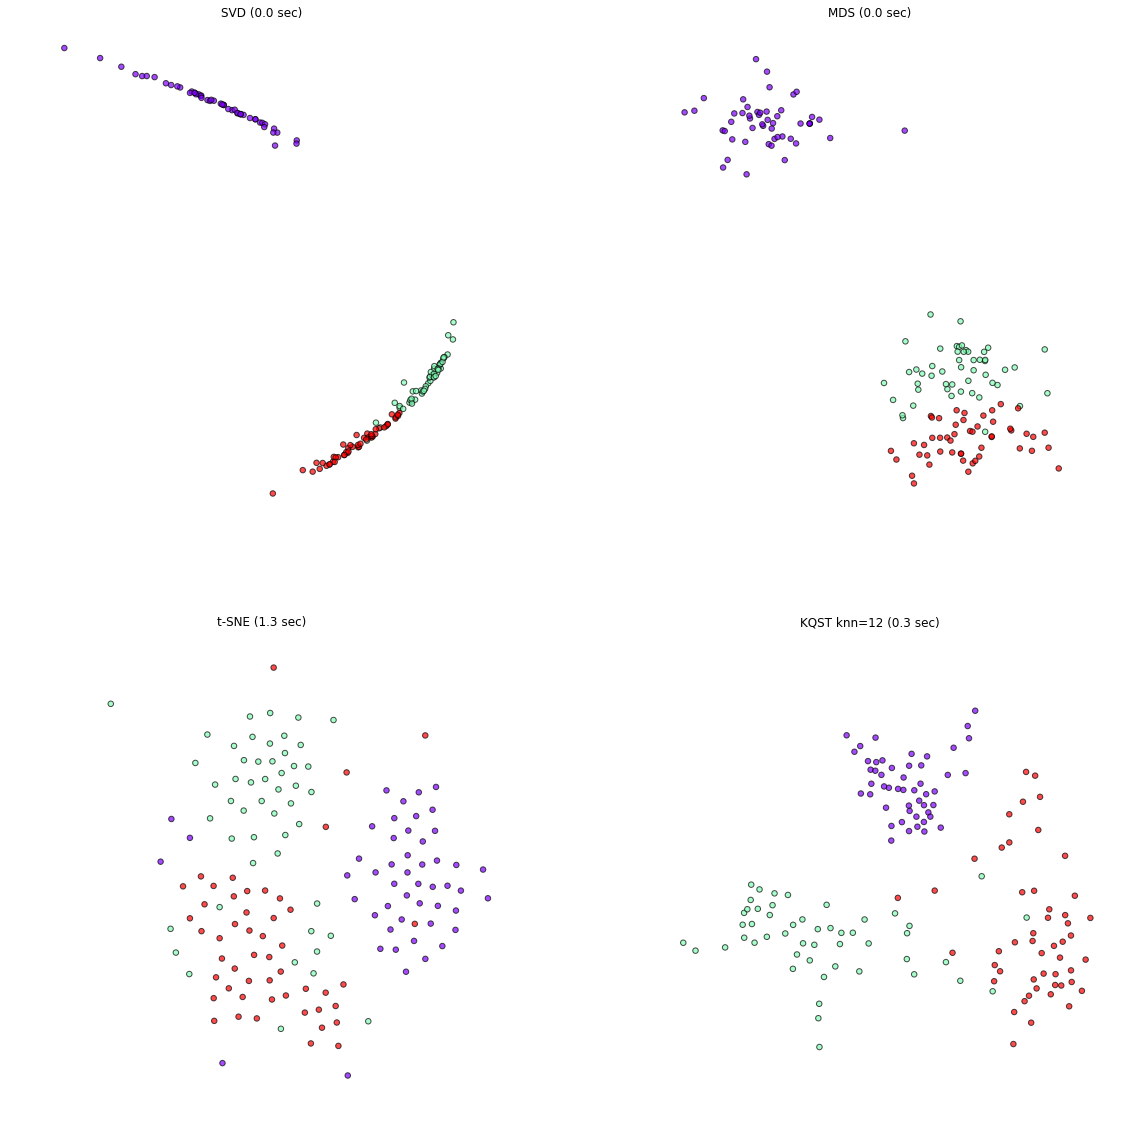

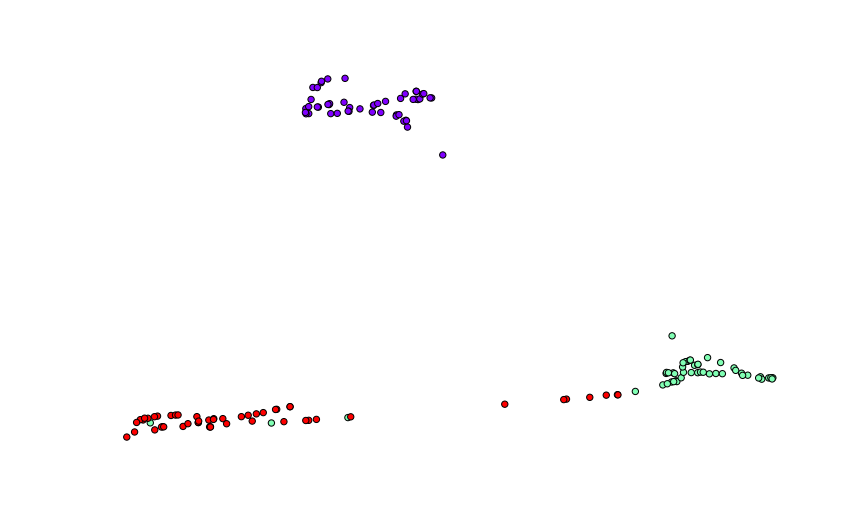

CPU times: user 2.78 s, sys: 159 ms, total: 2.94 s
Wall time: 3.86 s


In [419]:
%%time
%matplotlib inline
from sklearn import datasets
iris = datasets.load_iris()
X = iris.data
labels = iris.target
from sklearn.preprocessing import normalize,scale
X = normalize(X)
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.8, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*1), bias=2, n_nearest_neighbor_links=5)

Embedding quality [adjusted Rand index]: 0.97    data: (400, 10)   #classes: 8


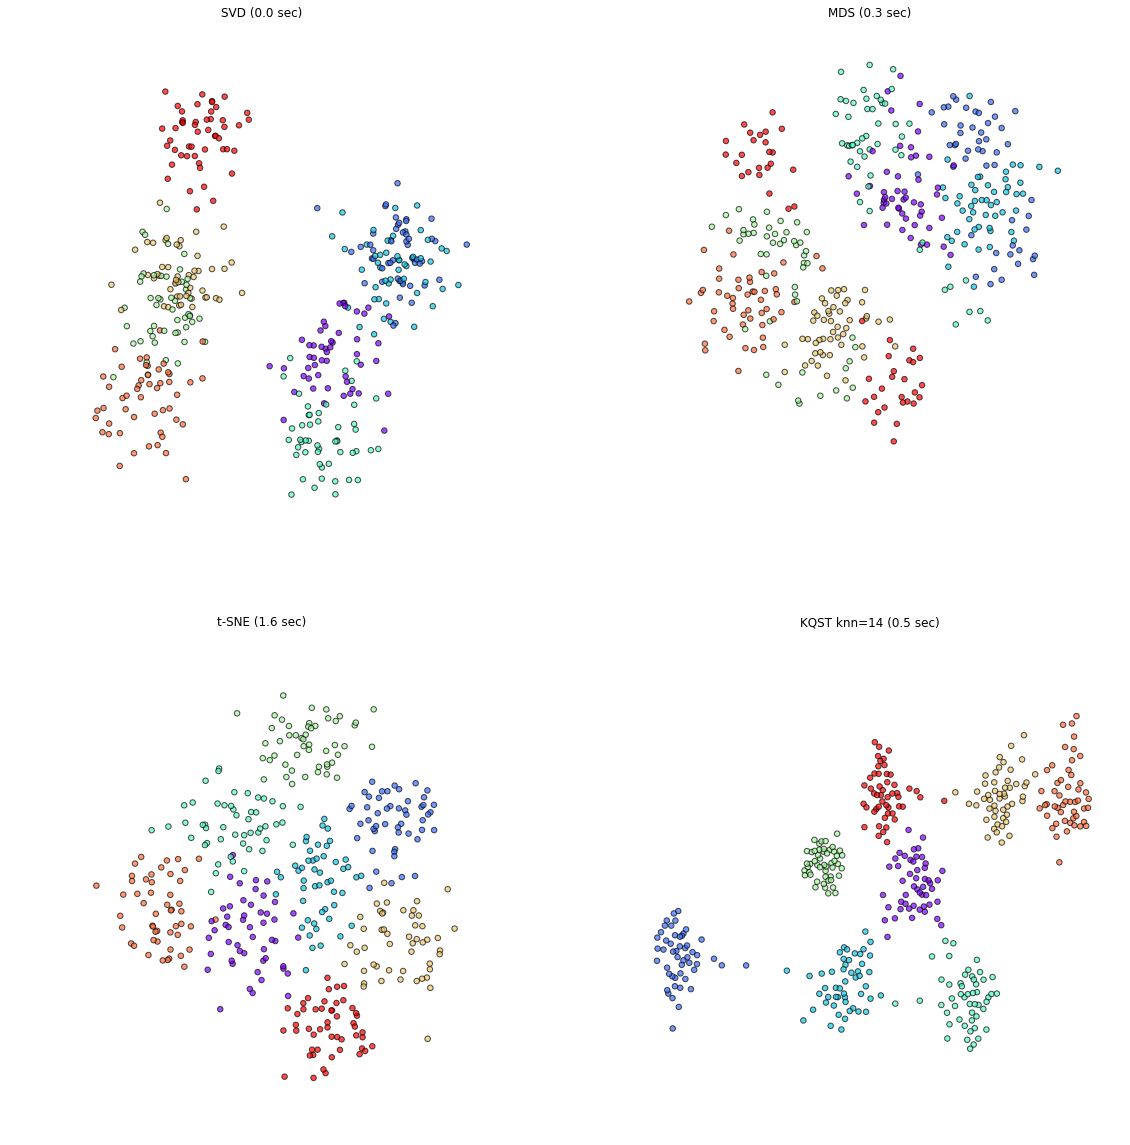

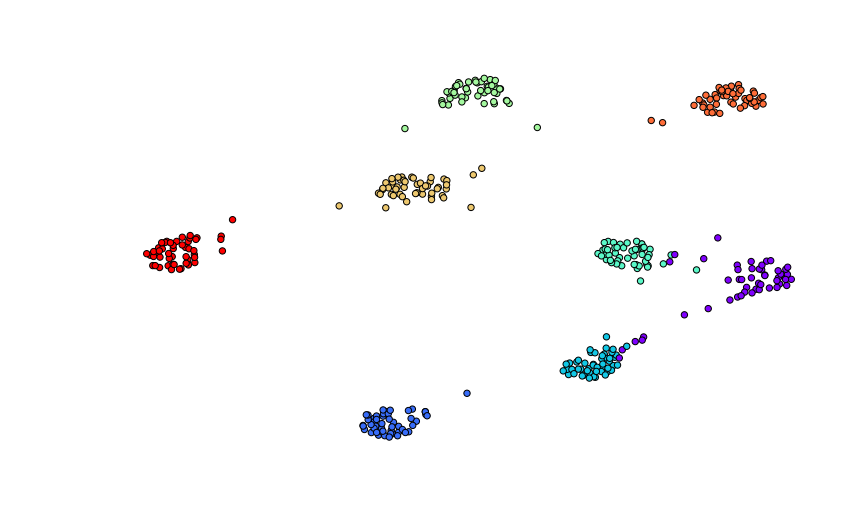

In [420]:
from sklearn.datasets.samples_generator import make_blobs
X, y = make_blobs(n_samples=400, centers=8, n_features=10, cluster_std=3, random_state=0)

opts={'knn': 14, 'k_threshold': 0.9, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*1), bias=1, n_nearest_neighbor_links=7)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: 0.74    data: (178, 13)   #classes: 3


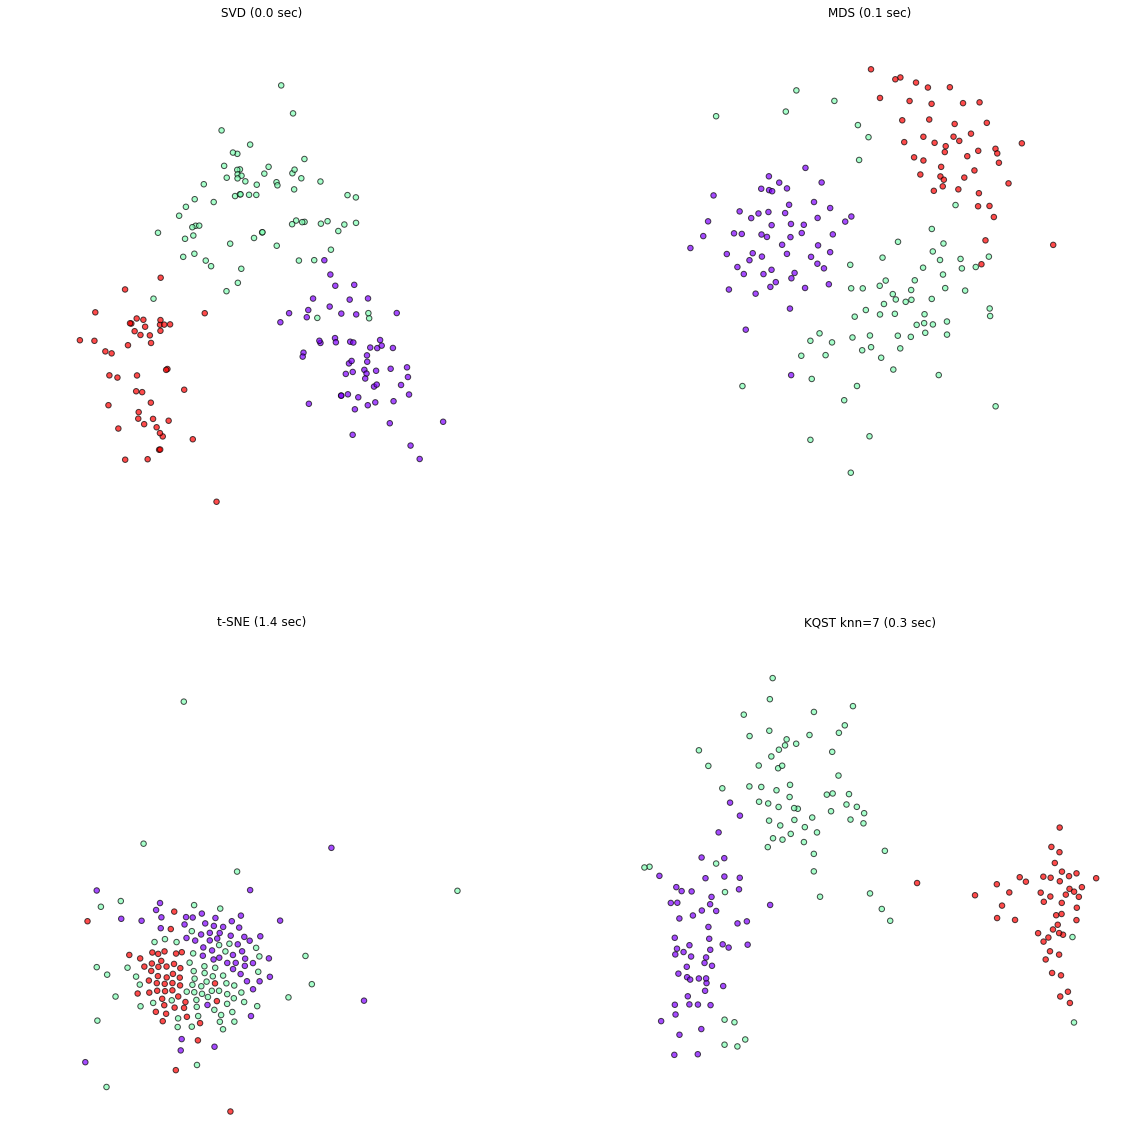

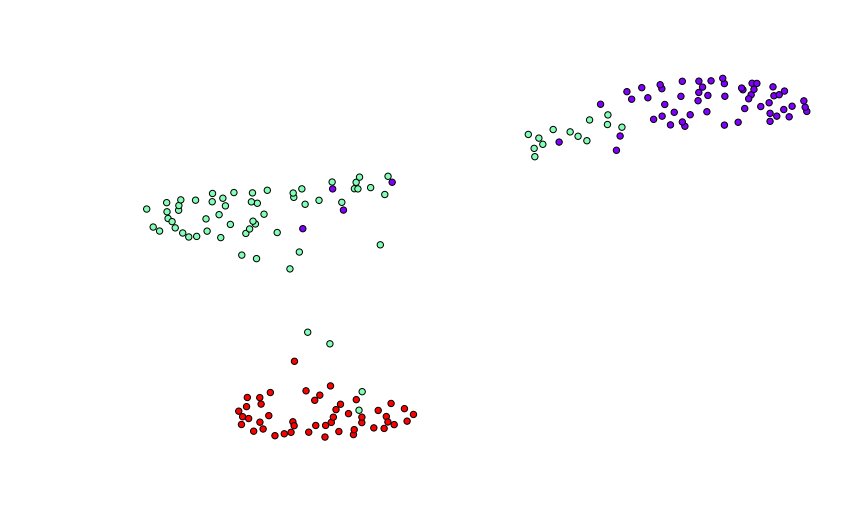

In [421]:
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data'
from eden.util import read
M=[]
labels=[]
for line in read(uri):
    line = line.strip()
    if line:
        items = line.split(',')
        label = int(items[0])
        labels.append(label)
        data = [float(x) for x in items[1:]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = scale(np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 7, 'k_threshold': 0.9, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*1), bias=1, n_nearest_neighbor_links=5)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: 0.13    data: (351, 34)   #classes: 2


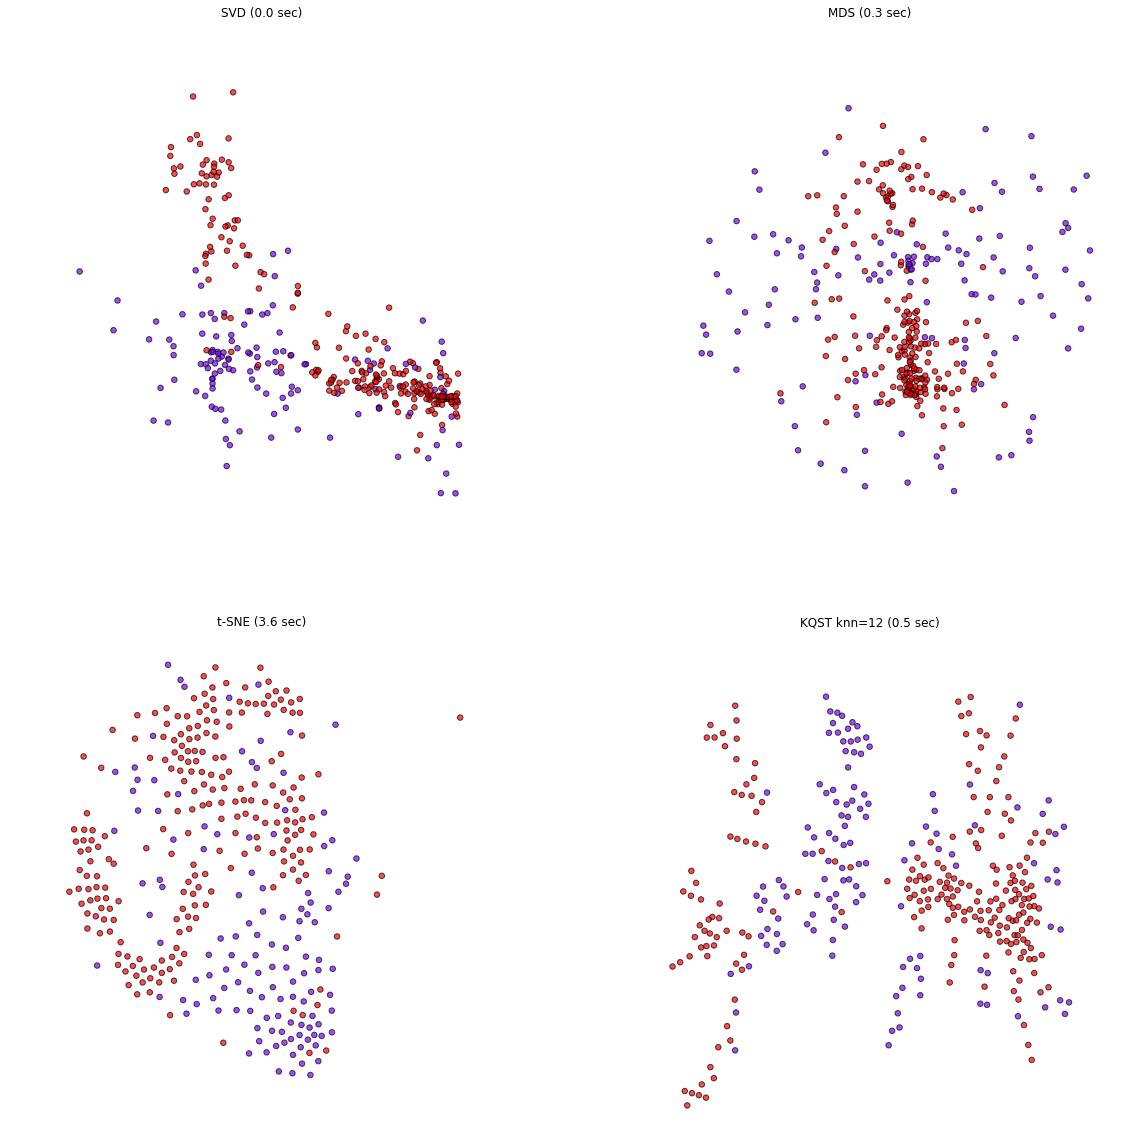

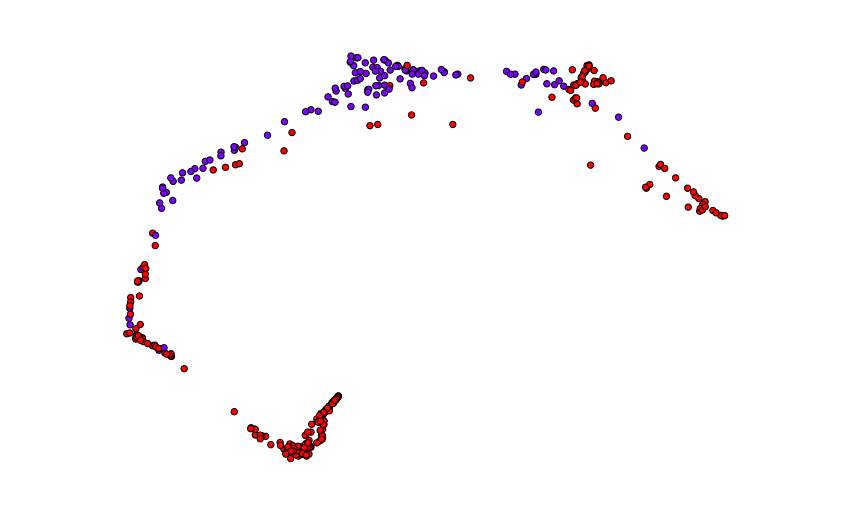

CPU times: user 6.27 s, sys: 331 ms, total: 6.6 s
Wall time: 8.69 s


In [411]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/ionosphere/ionosphere.data'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(',')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = (np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.90, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*3), bias=1, n_nearest_neighbor_links=5)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: 0.13    data: (699, 7)   #classes: 4


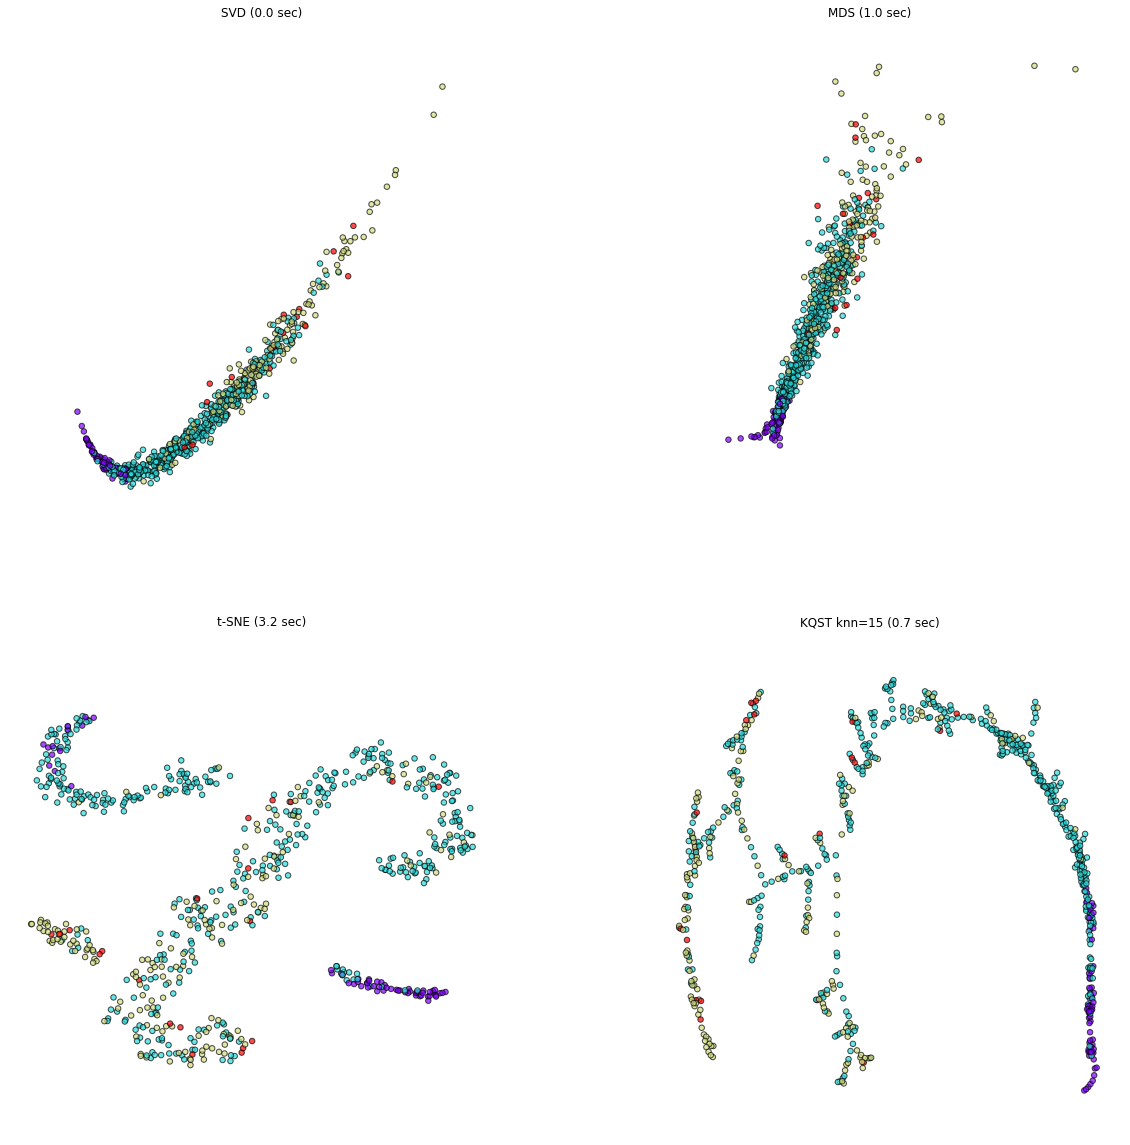

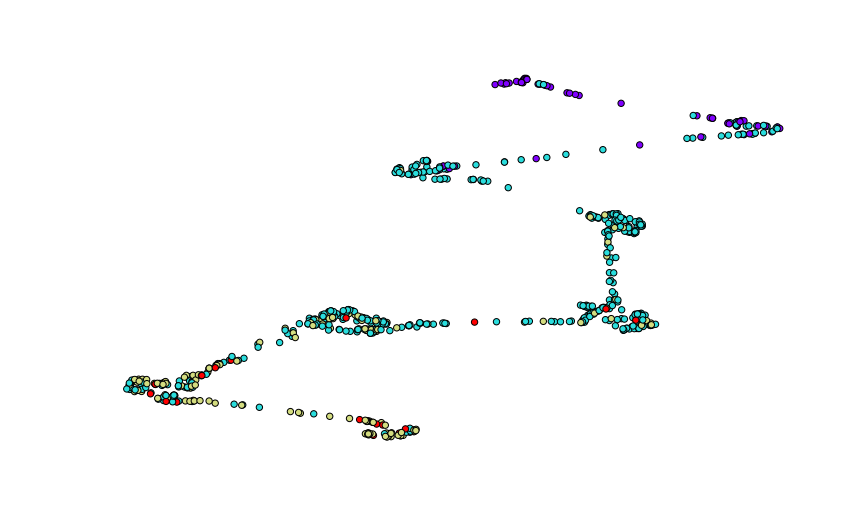

CPU times: user 19.7 s, sys: 542 ms, total: 20.2 s
Wall time: 22.6 s


In [412]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/abalone/abalone.data'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(',')
        label = int(items[-1])//7
        labels.append(label)
        data = [float(x) for x in items[1:-1]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
#X = scale(np.array(M))
X = np.array(M)
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

y_sel = select_targets(y, min_threshold=5)
X,y = filter_dataset(X, y, y_sel)

opts={'knn': 15,  'k_threshold': 0.98, 'gamma': 1e-3}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

data_matrix_corrcoef = np.corrcoef(X)
X = projector.fit_transform(X)
draw_2d_clust(data_matrix_corrcoef, y=y, n_clusters=int(len(set(y))*2), bias=2, n_nearest_neighbor_links=5)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: 0.03    data: (700, 8)   #classes: 2


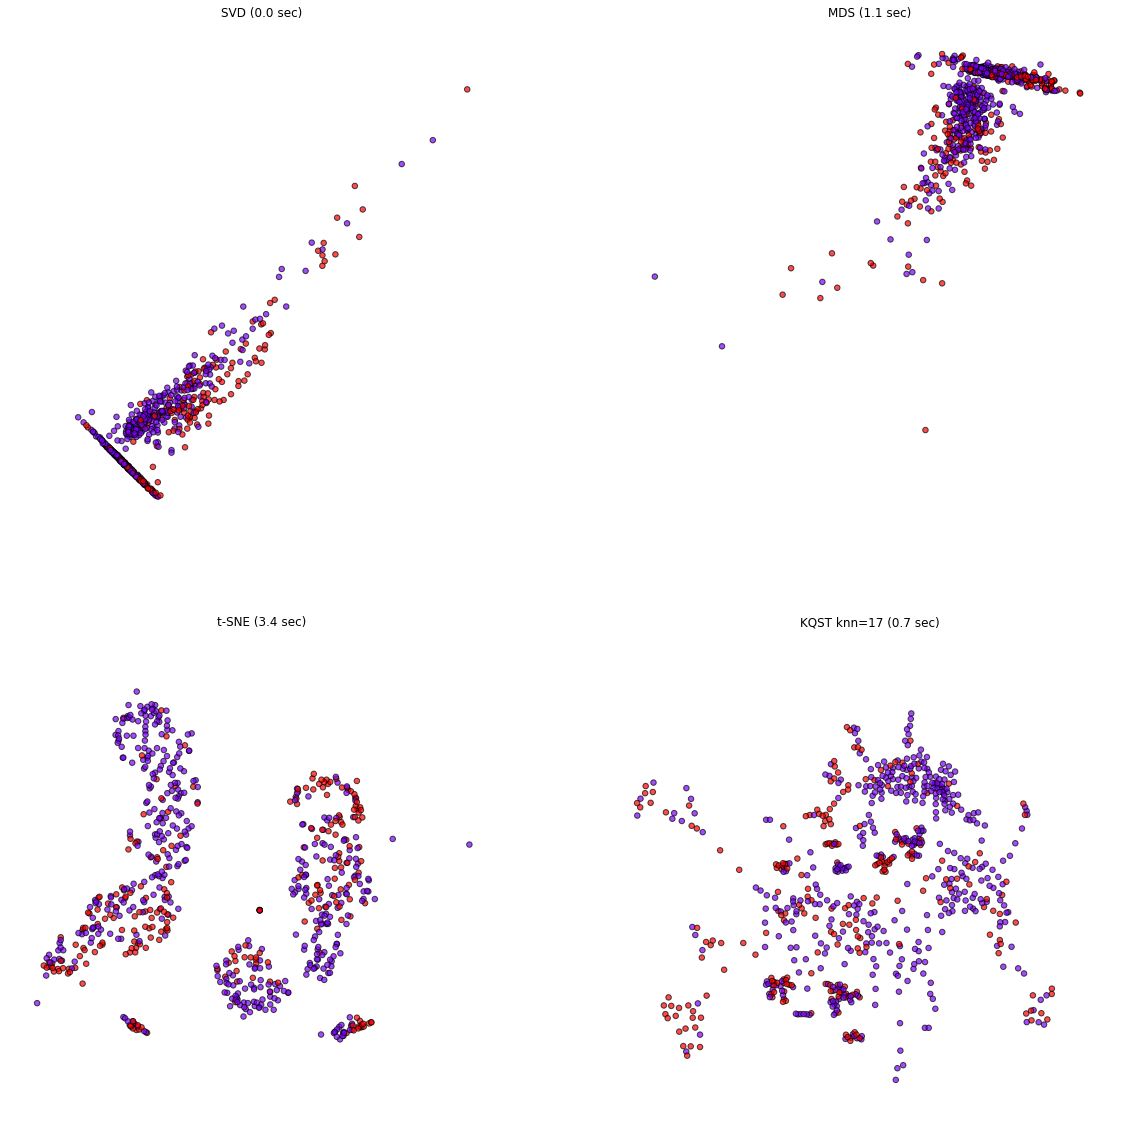

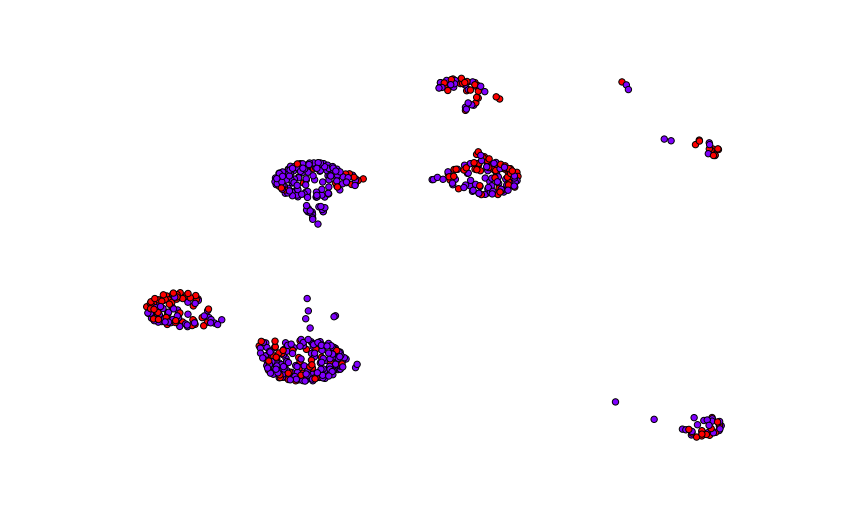

CPU times: user 18.8 s, sys: 423 ms, total: 19.2 s
Wall time: 21.1 s


In [408]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/pima-indians-diabetes/pima-indians-diabetes.data'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(',')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = (np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 17, 'k_threshold': 0.97, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

#X = np.corrcoef(X)
#X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*4), bias=1, n_nearest_neighbor_links=5)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: 0.10    data: (700, 41)   #classes: 2


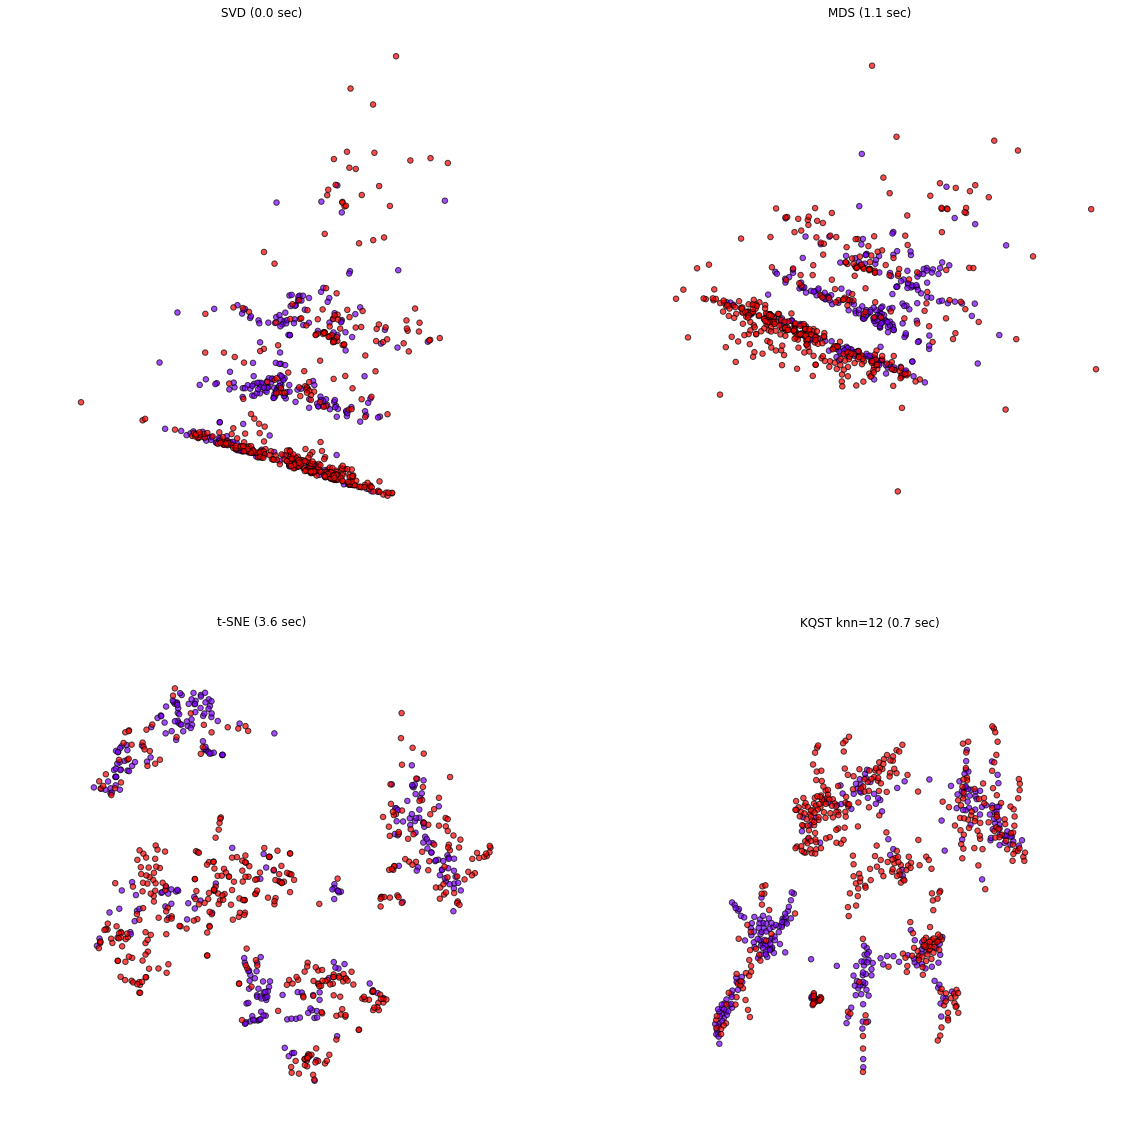

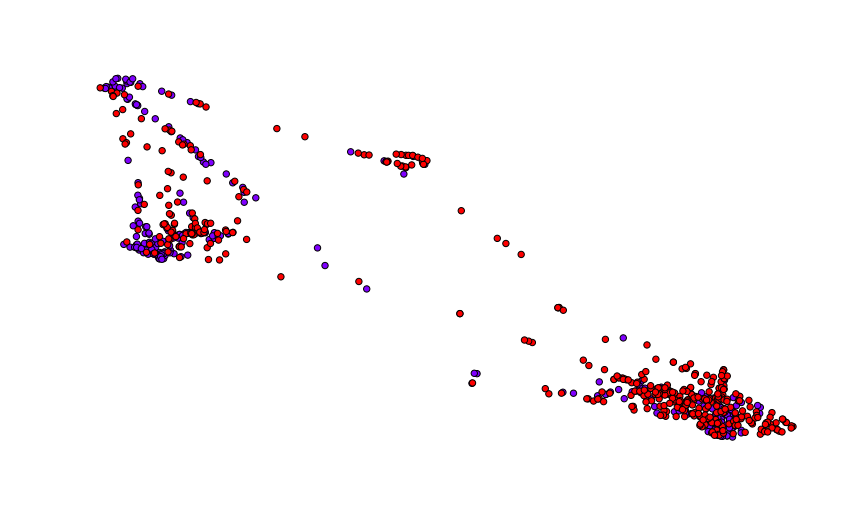

CPU times: user 19.6 s, sys: 422 ms, total: 20 s
Wall time: 22.3 s


In [415]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00254/biodeg.csv'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split(';')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

import numpy as np
from sklearn.preprocessing import normalize,scale
X = (np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.90, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
#X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*2), bias=1, n_nearest_neighbor_links=5)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: -0.01    data: (182, 12)   #classes: 2


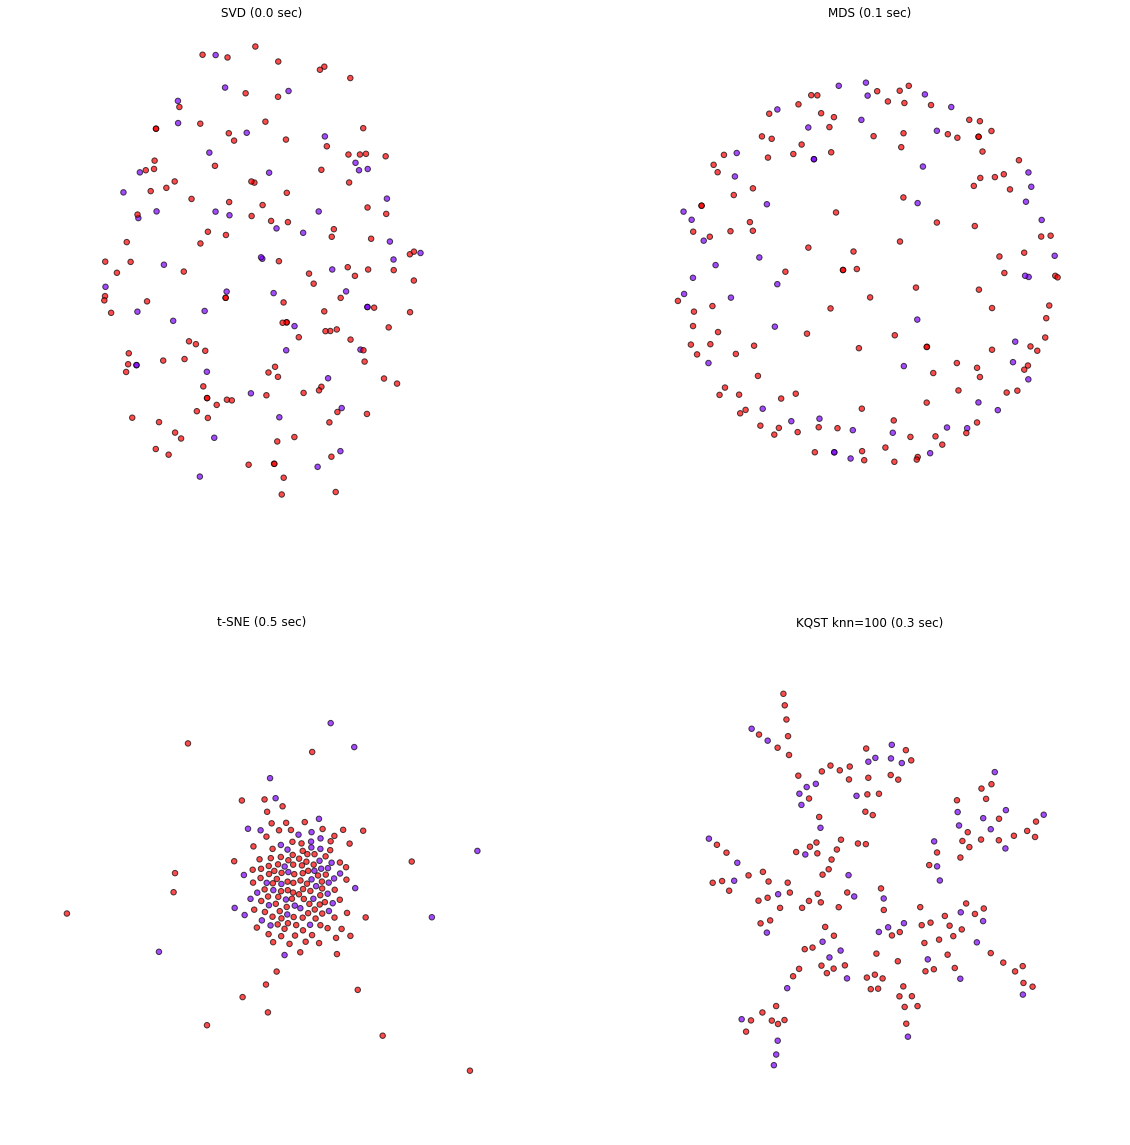

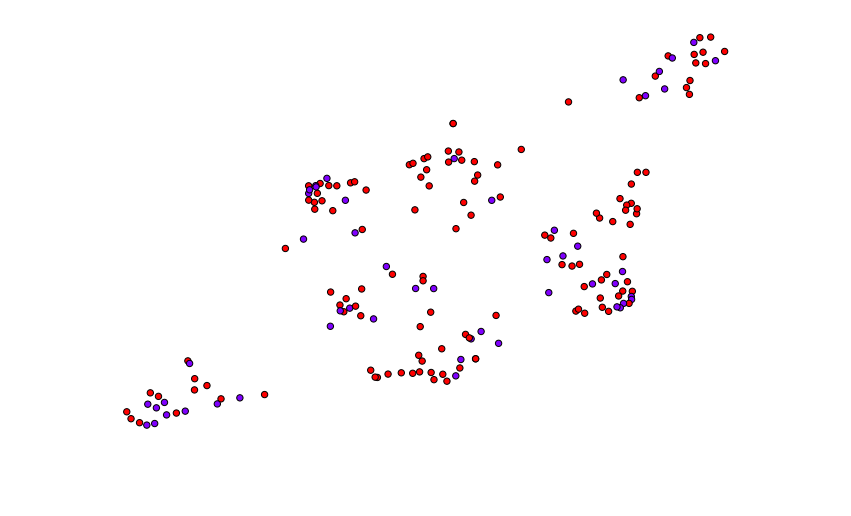

CPU times: user 2.4 s, sys: 124 ms, total: 2.53 s
Wall time: 4.15 s


In [347]:
%%time 
%matplotlib inline
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/00230/plrx.txt'
n_max=700

from eden.util import read
M=[]
labels=[]
counter = 0
for line in read(uri):
    counter += 1
    if counter > n_max:
        break
    line = line.strip()
    if line:
        items = line.split('\t')
        label = hash(items[-1])
        labels.append(label)
        data = [float(x) for x in items[:-1]]
        M.append(data)

import numpy as np
from sklearn.preprocessing import normalize,scale
X = normalize(np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 100, 'k_threshold': 0.5, 'gamma': 1e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*4), bias=2, n_nearest_neighbor_links=2)

Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: -0.00    data: (700, 18)   #classes: 2


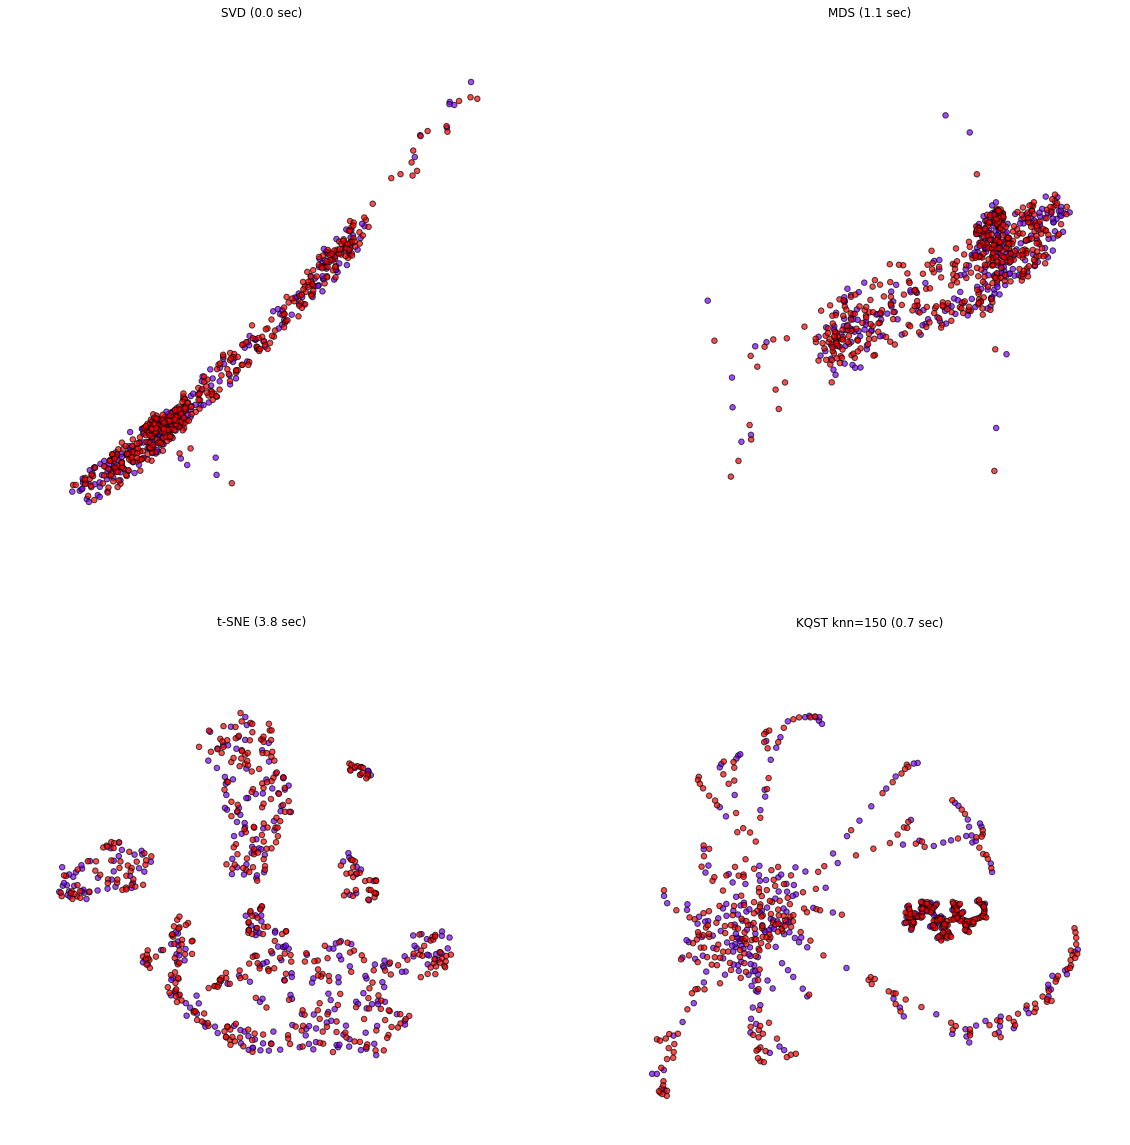

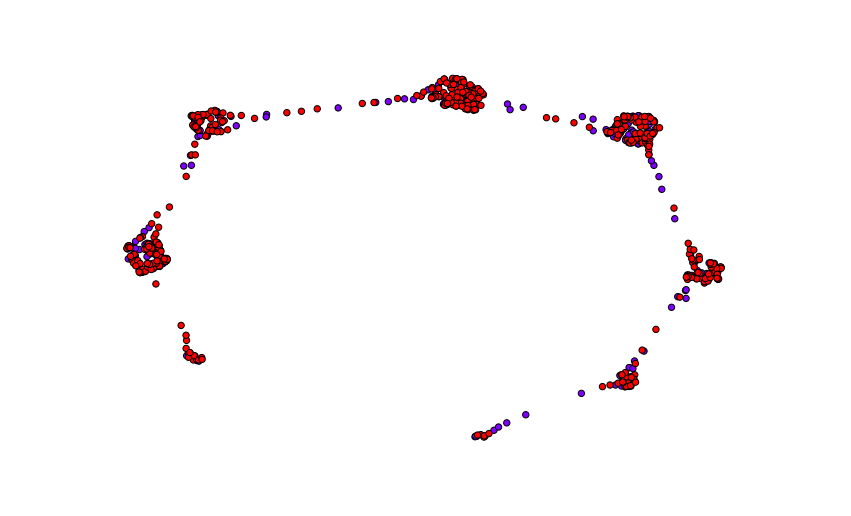

CPU times: user 19 s, sys: 421 ms, total: 19.5 s
Wall time: 26.4 s


In [382]:
%%time 
%matplotlib inline
import numpy as np

n_max = 500

def load_data(uri):
    from eden.util import read
    M=[]
    labels=[]
    counter = 0
    for line in read(uri):
        counter += 1
        if counter > n_max:
            break
        line = line.strip()
        if line:
            items = line.split(' ')
            label = hash(items[-1])&13
            labels.append(label)
            data = [float(x) for x in items[:-1]]
            M.append(data)
    X = np.array(M)
    y=np.array(labels)
    return X,y

for i,c in enumerate('abcdefghi'):
    uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/statlog/vehicle/xa%s.dat'%c
    X_,y_ = load_data(uri)
    if i==0:
        X=X_
        y=y_
    else:
        X=np.vstack((X,X_))
        y=np.hstack((y,y_))

from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)       
y_sel = select_targets(y, min_threshold=10)
X,y = filter_dataset(X, y, y_sel)


opts={'knn': 150, 'k_threshold': 0.85, 'gamma': 1e-4}
low_dim = 5
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts, low_dim=low_dim), X.shape, len(set(y)))
display_embedding(X,y, opts)

X = np.corrcoef(X)
X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*4), bias=2, n_nearest_neighbor_links=2)

Starting new HTTP connection (1): archive.ics.uci.edu
Embedding quality [adjusted Rand index]: 0.69    data: (569, 30)   #classes: 2


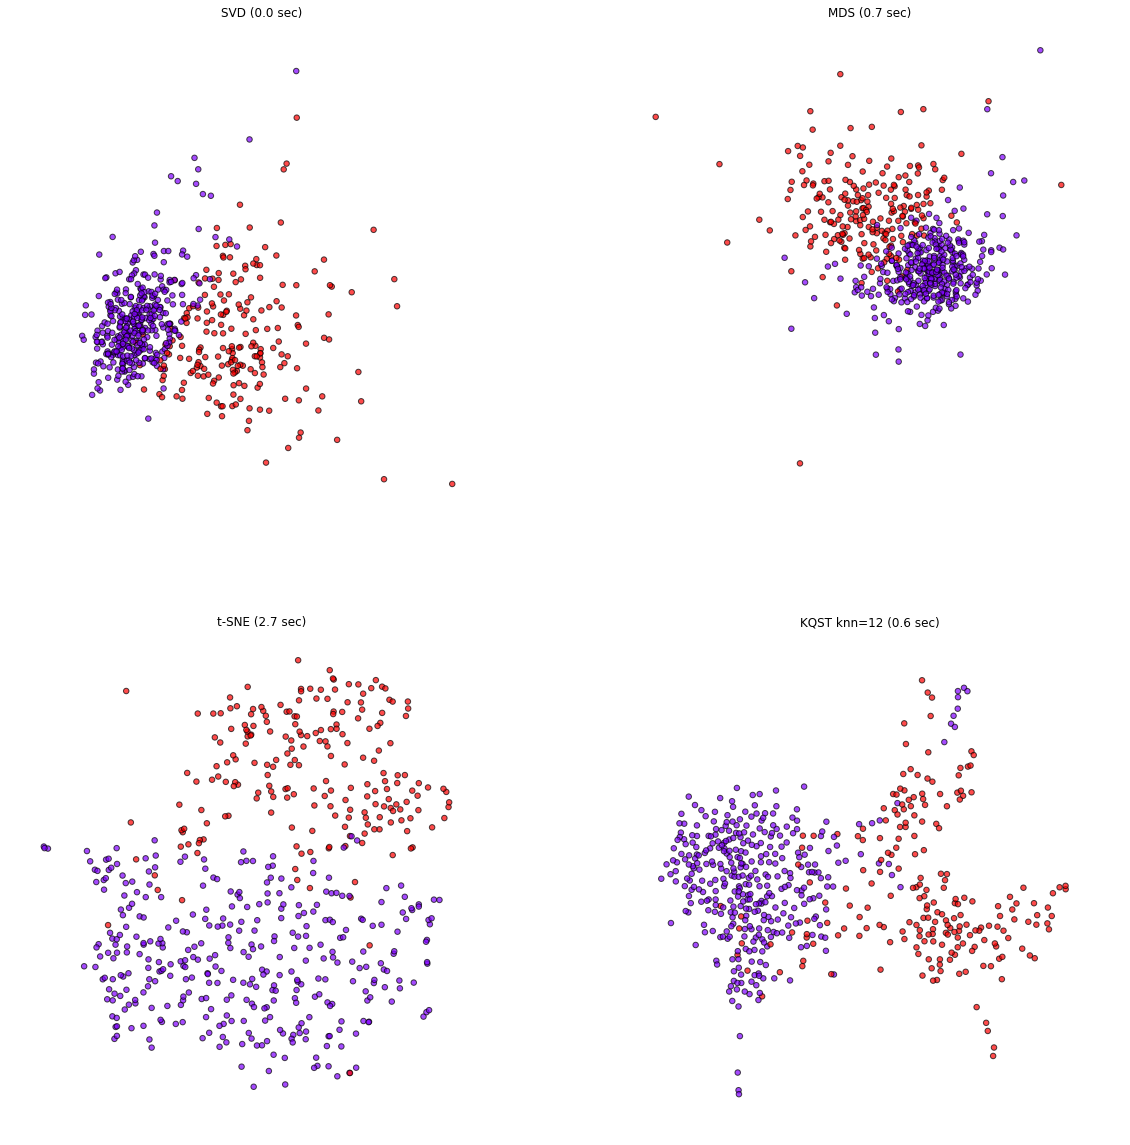

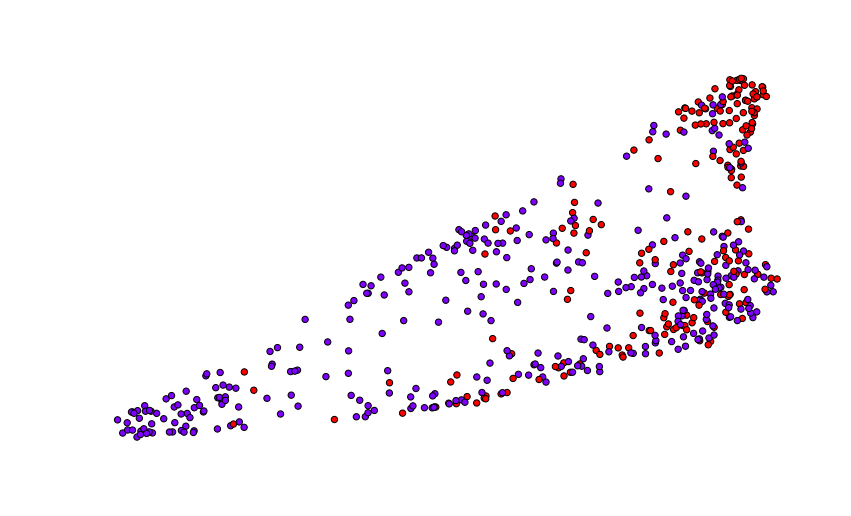

CPU times: user 15.1 s, sys: 330 ms, total: 15.5 s
Wall time: 17.6 s


In [386]:
%%time
%matplotlib inline
#breast-cancer-wisconsin
uri = 'http://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'
from eden.util import read
M=[]
labels=[]
for line in read(uri):
    line = line.strip()
    if line:
        items = line.split(',')
        label = str(items[1])
        labels.append(label)
        data = [float(x) for x in items[2:]]
        M.append(data)

            
import numpy as np
from sklearn.preprocessing import normalize,scale
X = scale(np.array(M))
from sklearn.preprocessing import LabelEncoder
targets = LabelEncoder().fit_transform(labels)
y=np.array(targets)

opts={'knn': 12, 'k_threshold': 0.75, 'gamma': 5e-2}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)


X = np.corrcoef(X)
X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*3), bias=.5, n_nearest_neighbor_links=7)

Embedding quality [adjusted Rand index]: 0.88    data: (1264, 64)   #classes: 7


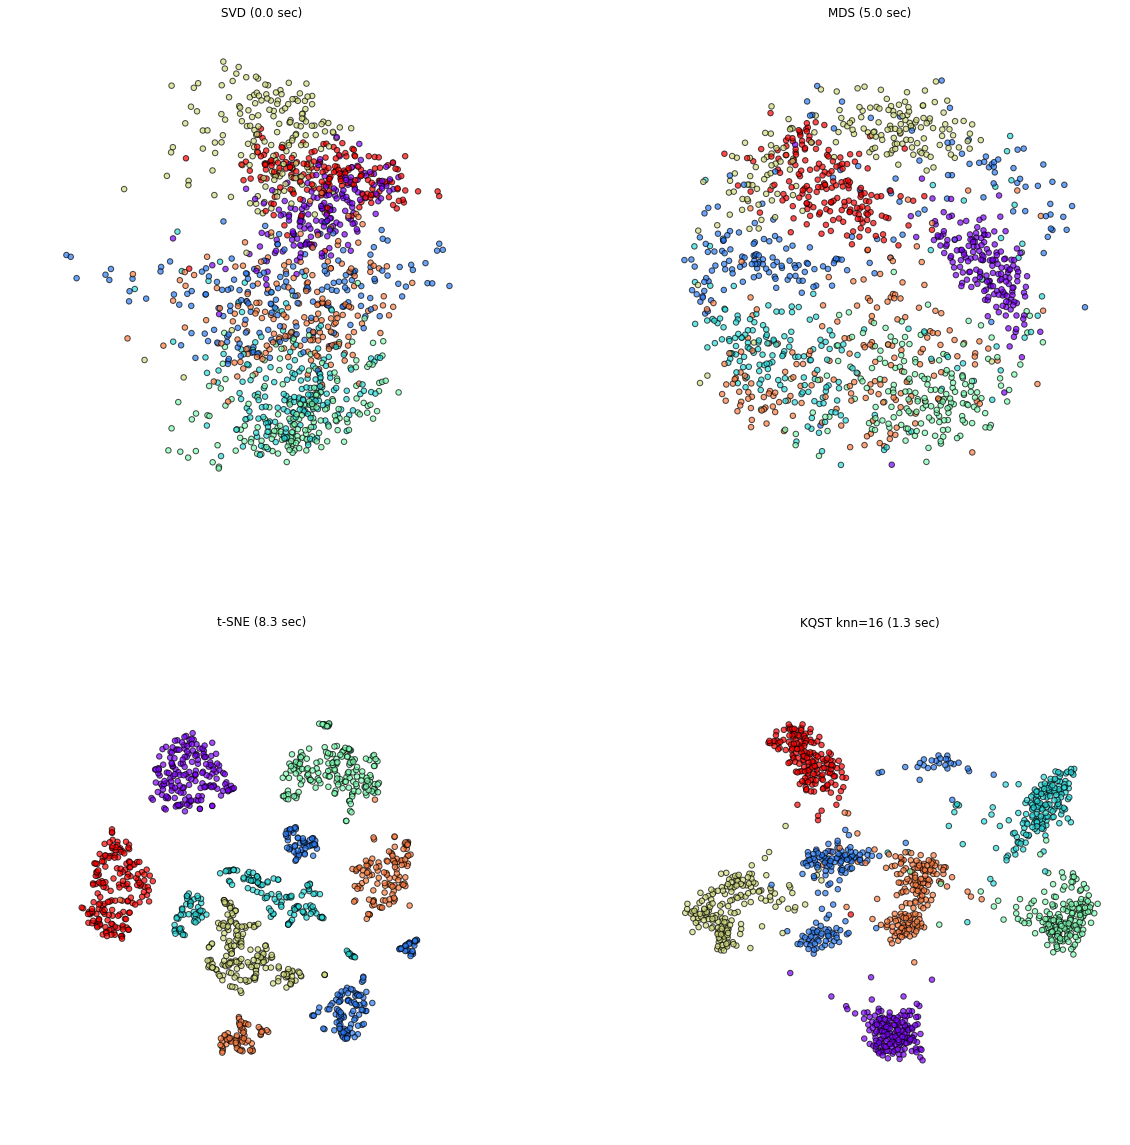

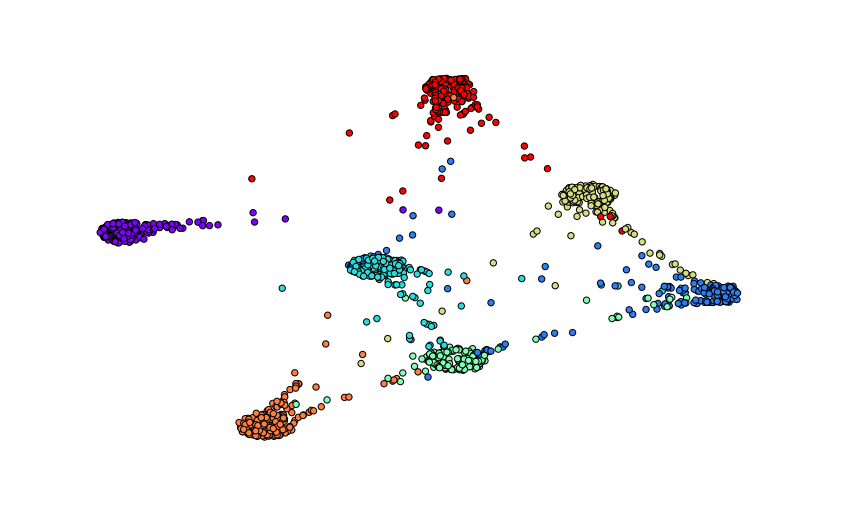

CPU times: user 43.1 s, sys: 2.08 s, total: 45.2 s
Wall time: 46.9 s


In [418]:
%%time
%matplotlib inline
from sklearn import datasets
digits = datasets.load_digits(n_class=7)
X = digits.data
y = digits.target
from sklearn.preprocessing import normalize,scale
X = normalize(X)

opts={'knn': 16, 'k_threshold': 0.9, 'gamma': 1e-4}
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts), X.shape, len(set(y)))
display_embedding(X,y, opts)

#X = np.corrcoef(X)
#X = projector.fit_transform(X)
draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*1), bias=2, n_nearest_neighbor_links=2)

Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
Starting new HTTP connection (1): www.bioinf.uni-freiburg.de
Embedding quality [adjusted Rand index]: -0.00    data: (600, 150)   #classes: 2


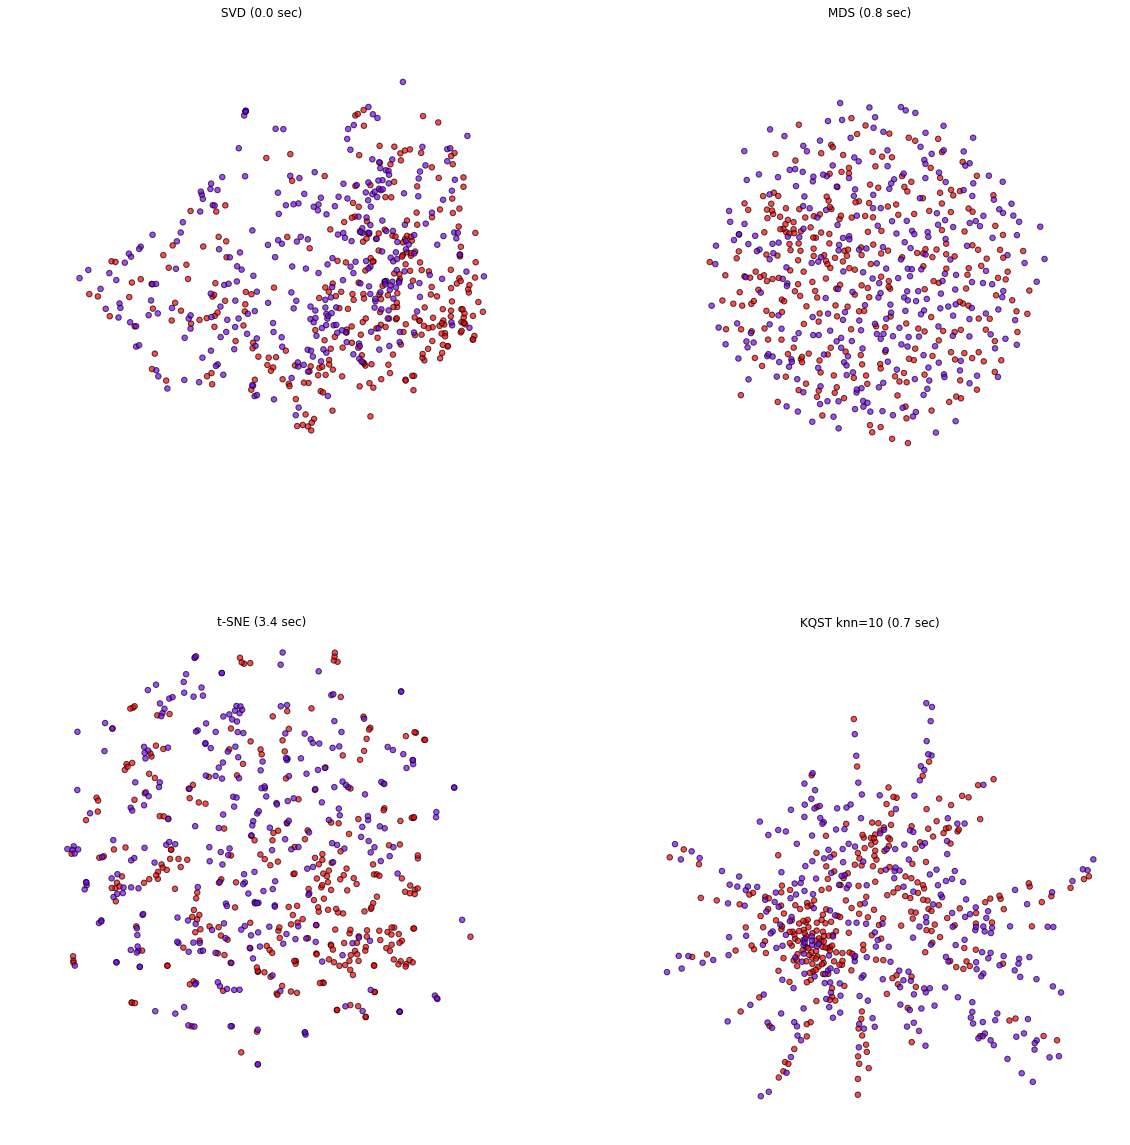

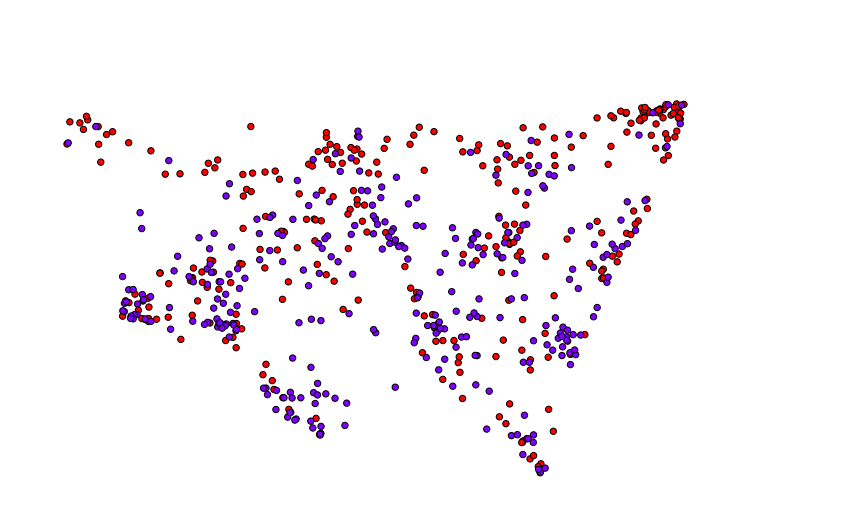

CPU times: user 33.2 s, sys: 1.68 s, total: 34.9 s
Wall time: 30.5 s


In [315]:
%%time
%matplotlib inline

from eden.converter.graph.gspan import gspan_to_eden
from itertools import islice
n_max=300
pos_graphs = islice(gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi_pos_train.gspan'),n_max)
neg_graphs = islice(gspan_to_eden('http://www.bioinf.uni-freiburg.de/~costa/bursi_neg_train.gspan'),n_max)

from eden.graph import Vectorizer
vectorizer = Vectorizer(complexity=3, nbits=17)

import numpy as np
from scipy.sparse import vstack
Xpos = vectorizer.transform(pos_graphs)
Xneg = vectorizer.transform(neg_graphs)
yp = [1] * Xpos.shape[0]
yn = [0] * Xneg.shape[0]
y = np.array(yp + yn)
X = vstack([Xpos, Xneg], format="csr")
from sklearn.decomposition import TruncatedSVD
X = TruncatedSVD(n_components=150).fit_transform(X)

opts={'knn': 10, 'k_threshold': 0.95, 'gamma': 1e-3}
low_dim = 200
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts, low_dim=low_dim), X.shape, len(set(y)))
display_embedding(X,y, opts)

data_matrix_corrcoef = np.corrcoef(X)
draw_2d_clust(data_matrix_corrcoef, y=y, n_clusters=int(len(set(y))*8), bias=2, n_nearest_neighbor_links=10)

In [ ]:
import time
def rfam_uri(family_id):
        return 'http://rfam.xfam.org/family/%s/alignment?acc=%s&format=fastau&download=0'%(family_id,family_id)

def rfam_to_matrix(rfam_id, n_max=50, complexity=2):
    from eden.converter.fasta import fasta_to_sequence
    seqs = fasta_to_sequence(rfam_uri(rfam_id))
    from itertools import islice
    seqs = islice(seqs,n_max)
    rs = int(time.time())
    from eden.RNA import Vectorizer
    rnavec=Vectorizer(complexity=complexity, n_neighbors=30, sampling_prob=.1, n_iter=40, random_state=rs)
    X = rnavec.fit_transform(seqs)
    return X

def rfam_data(rfam_ids, n_max=100, complexity=2):
    import numpy as np
    from scipy.sparse import vstack
    for i,rfam_id in enumerate(rfam_ids):
        X_=rfam_to_matrix(rfam_id, n_max=n_max, complexity=complexity)
        y_ = [i] * X_.shape[0]
        if i==0:
            X=X_
            y=y_
        else:
            X = vstack([X, X_], format="csr")
            y=y+y_
    y = np.array(y)
    return X,y

rfam_ids=['RF00004','RF00005','RF00015','RF00020','RF00026','RF00169',
          'RF00380','RF00386','RF01051','RF01055','RF01234','RF01699',
          'RF01701','RF01705','RF01731','RF01734','RF01745','RF01750',
          'RF01942','RF01998','RF02005','RF02012','RF02034']

X,y = rfam_data(rfam_ids[0:4],n_max=400, complexity=3)
from sklearn.decomposition import TruncatedSVD
X = TruncatedSVD(n_components=50).fit_transform(X)

opts={'knn': 5, 'k_threshold': 0.97, 'gamma': 1e-3}
low_dim = 200
print 'Embedding quality [adjusted Rand index]: %.2f    data: %s   #classes: %d' % (embedding_quality(X, y, opts, low_dim=low_dim), X.shape, len(set(y)))
display_embedding(X,y, opts)


draw_2d_clust(X, y=y, n_clusters=int(len(set(y))*1), bias=5)

--------